# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:180%; font-family:Arial, sans-serif; background-color:#BCE5FB; color:#013D41; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> Anomaly Detection: Credit Card Fraud </b></div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2

palette = ['#00777F', '#5BABF5', '#AADEFE', '#EAAC9F', '#8AA0AF']
sns.set_theme(context='notebook', palette=palette, style='darkgrid')

# Suppress the FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset has 284807 rows and 31 columns.


In [ ]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

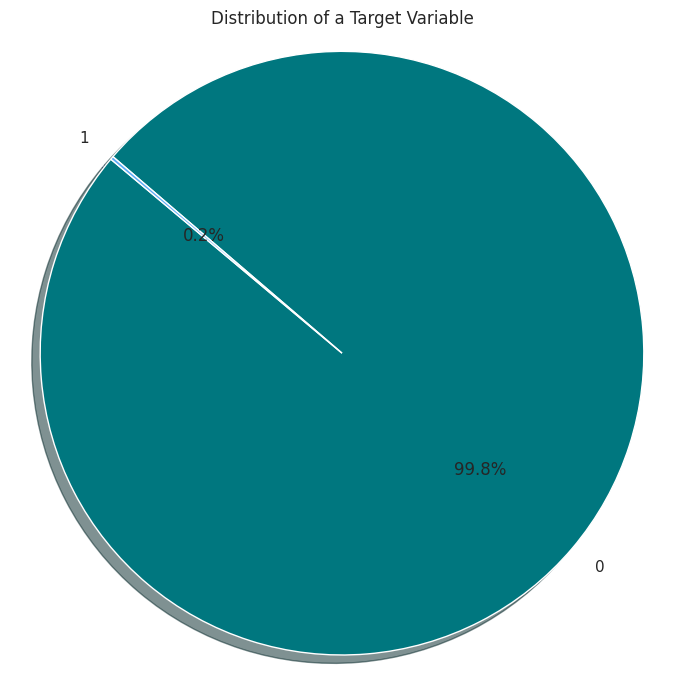

In [ ]:
# Count the occurrences of each category
status_counts = df.Class.value_counts()

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=palette, shadow=True)

plt.title('Distribution of a Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

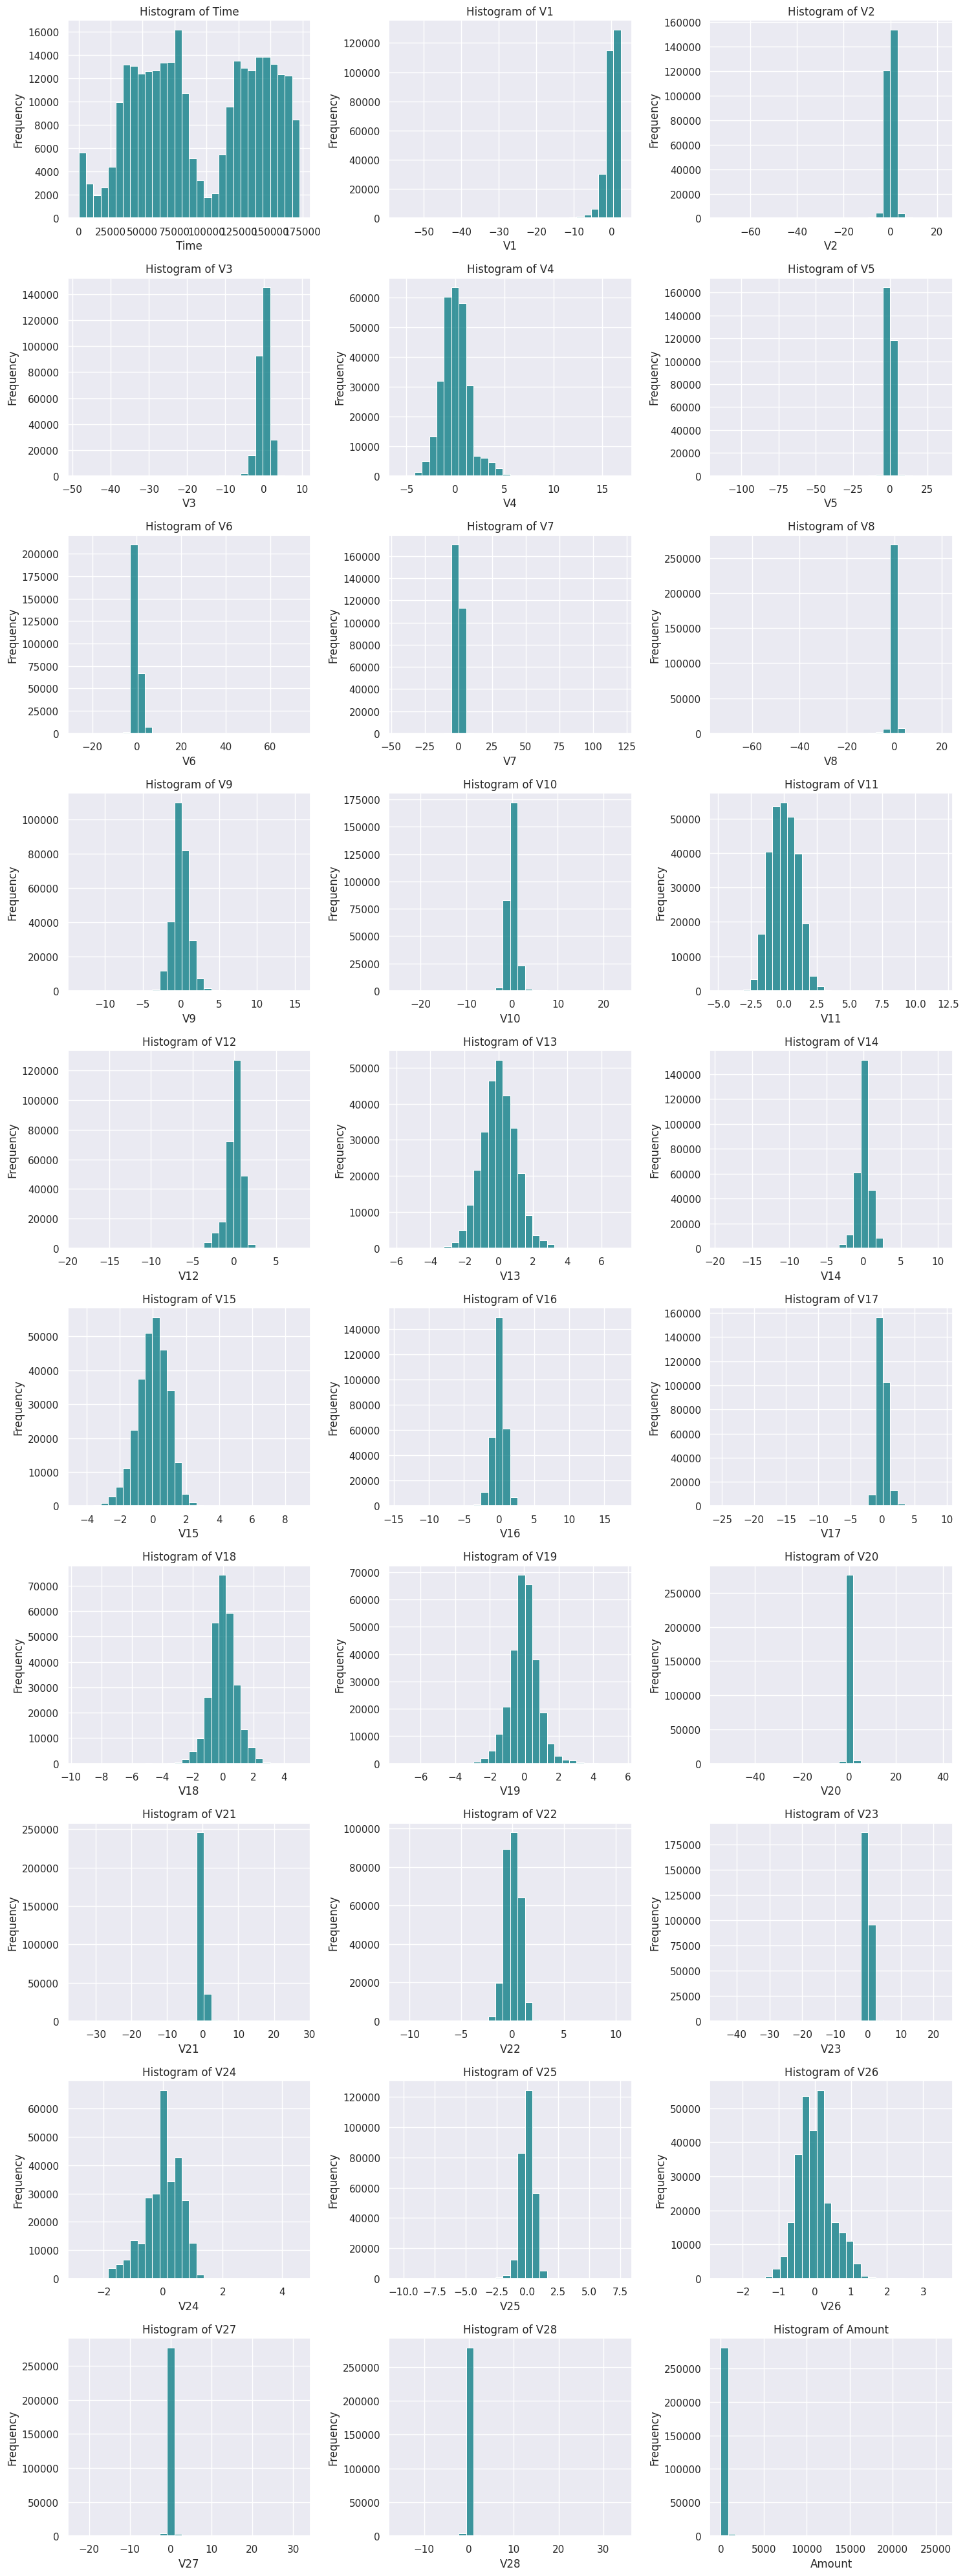

In [ ]:
# Feature names
features = df.columns[:-1]

# Set up the figure; 10 rows (10*3=30 subplots), adjust as needed
fig, axes = plt.subplots(10, 3, figsize=(15, 40))  # Adjust rows to fit all features

# Flatten axes array to loop through easily
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    sns.histplot(df[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if features < 30
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#015156; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> ⚖️ 4. Feature Transformation </b></div>

<div style="border: 2px solid #00777F; padding: 15px; border-radius: 10px;">
    <p style="font-size: 16px">
        Feature transformation plays an essential role in anomaly detection. Many anomaly detection techniques work best when the data follows a Gaussian (normal) distribution. If our features are skewed (i.e., they have long tails in one direction) or are on different scales, these algorithms may struggle to accurately identify normal data points and anomalies. This could lead to normal instances being wrongly flagged as outliers or genuine anomalies being overlooked.
    </p>
    <p style="font-size: 16px">
        According to our histogram plots, many of our features are highly skewed. To address this issue, we will apply log transformations; therefore, we will stabilize variance, reduce skewness, and enhance the interpretability of the data. This ensures that the characteristics of the data align more closely with the assumptions of the model, thereby improving its ability to accurately identify anomalies and enhancing the overall reliability of the detection process.
    </p>
</div>

In [ ]:
# Create a copy of the DataFrame to avoid changing the original
df_transformed = df.copy()

# Function to handle log transformation for skewed data
def log_transform_skewed(column):
    # For positive and zero values (log1p avoids log(0) errors)
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Compute skewness before transformation
skewness_before = df.skew()

# Apply transformation to skewed columns
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Compute skewness after transformation
skewness_after = df_transformed.skew()

# Compare skewness before and after
skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After': skewness_after
})

# Print the comparison
skewness_comparison

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Skewness Before,Skewness After
Time,-0.035568,-0.035568
V1,-3.280667,-0.364893
V2,-4.624866,-0.310128
V3,-2.240155,-0.315192
V4,0.676292,0.676292
V5,-2.425901,0.139077
V6,1.826581,0.804345
V7,2.553907,-0.112666
V8,-8.521944,-0.912642
V9,0.554680,0.554680


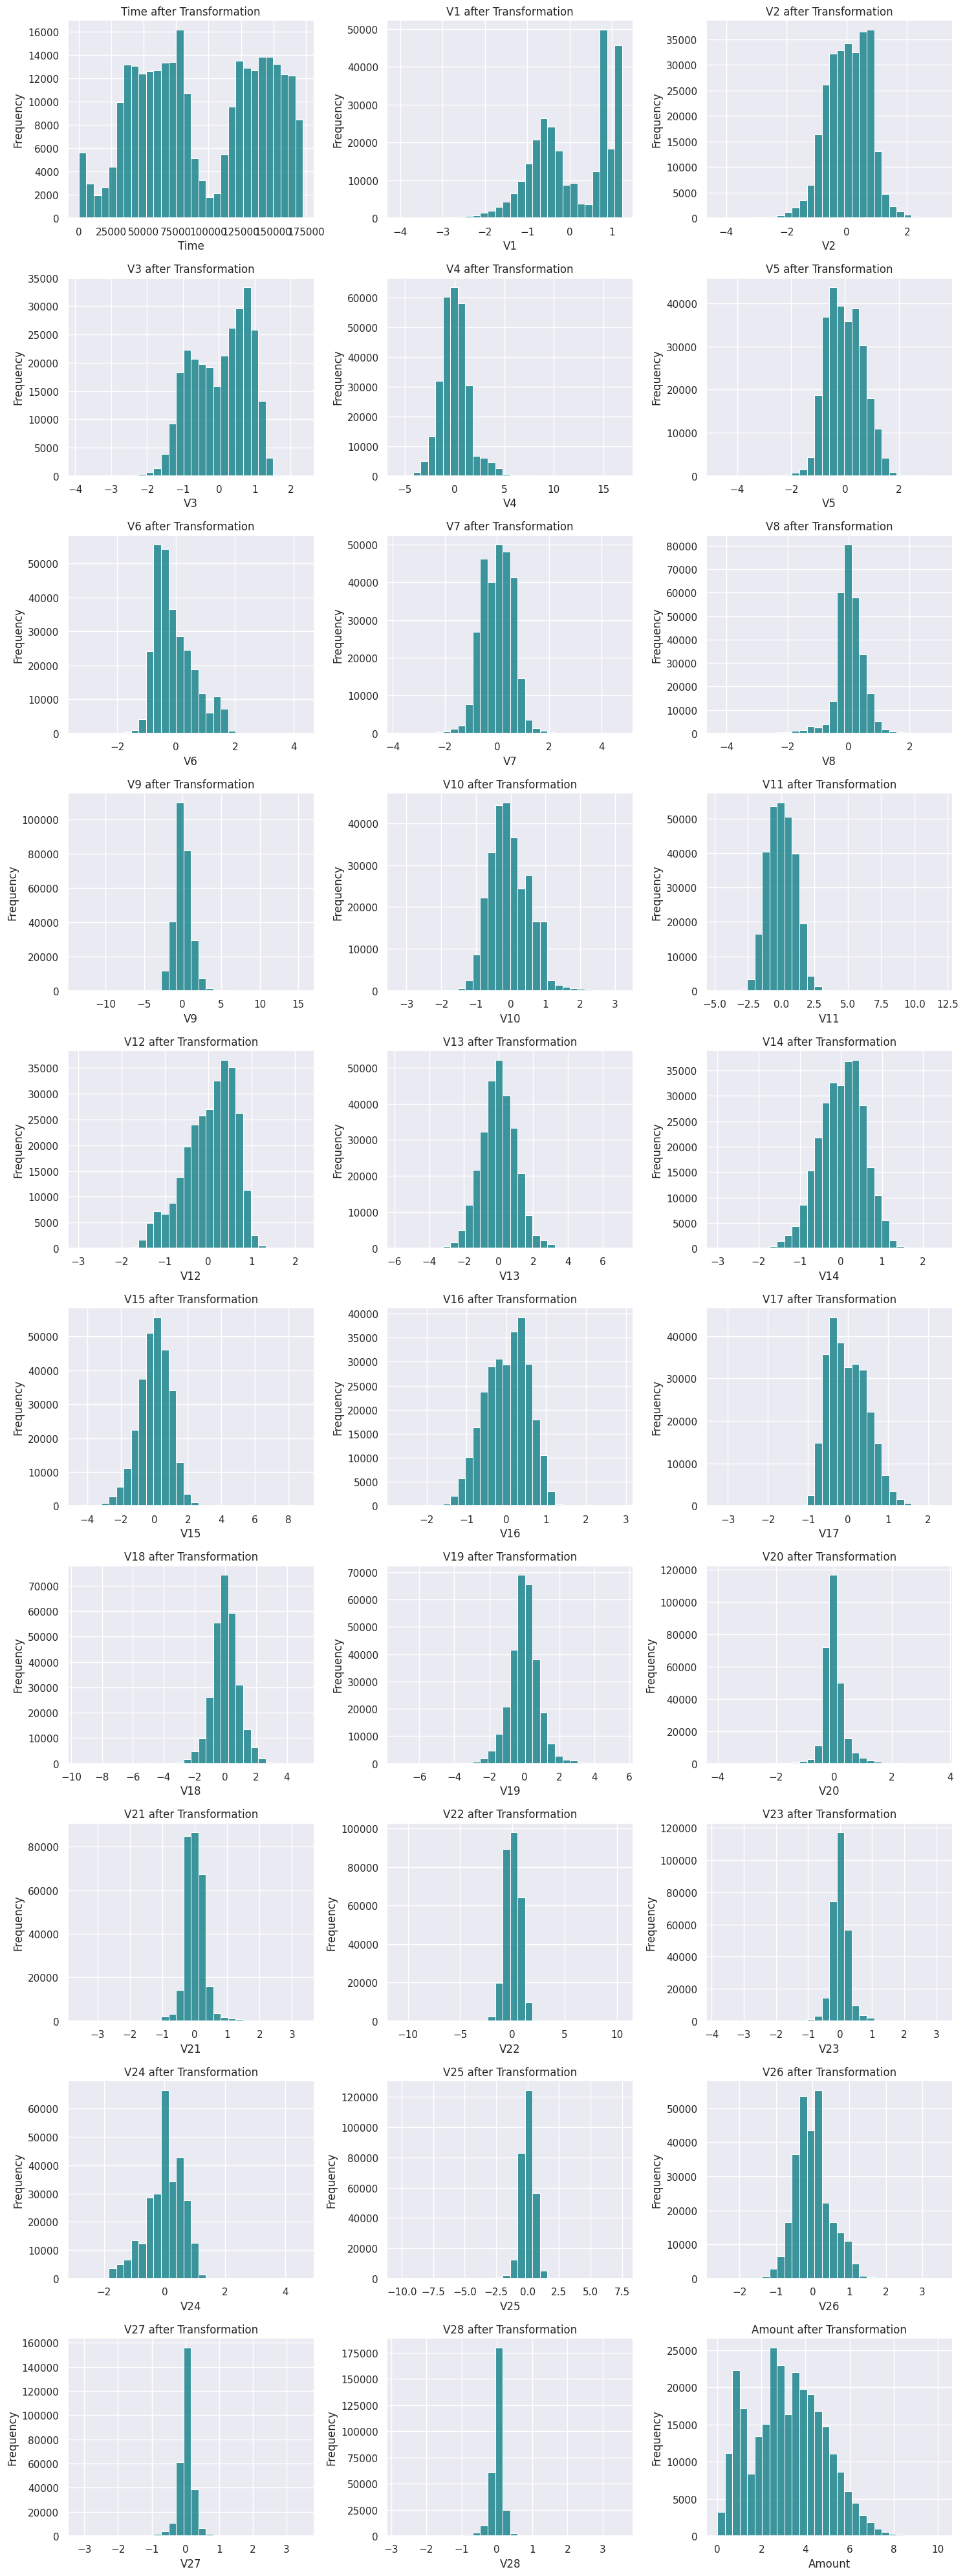

In [ ]:
# Set up the figure; 10 rows (10*3=30 subplots), adjust as needed
fig, axes = plt.subplots(10, 3, figsize=(15, 40))  # Adjust rows to fit all features

# Flatten axes array to loop through easily
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    sns.histplot(df_transformed[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'{feature} after Transformation')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if features < 30
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
# Separate features and target
X = df_transformed[features]
y = df_transformed.Class

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#015156; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 🌲 5. Isolation Forest </b></div>

![iso](https://img.notionusercontent.com/s3/prod-files-secure%2F4c8e53cf-9e22-4a29-88da-098b521218a1%2Fcf1c1d99-47bb-4a34-aec5-3431a929335f%2FUntitled.png/size/?exp=1728163532&sig=QPm47I3WnH13AyISXIi4uix5_bd8NRWTshn5RLn3Y6Y)

Image taken from [here](https://wiki.datrics.ai/isolation-forest-model).

<div style="border: 2px solid #00777F; padding: 15px; border-radius: 10px;">
    <p style="font-size: 16px">
        <strong>🌲 Isolation Forest</strong>: This technique works by randomly selecting features and splitting data points. Anomalies, or outliers, are easier to isolate, resulting in shorter paths in the "forest." It's effective for large datasets, as it can quickly identify anomalies without needing to model the data's distribution. However, it may miss complex patterns since it relies on simple random splits.
    </p>
</div>

In [ ]:
# Initialize the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=101)   # high contamination to catch more fraud transactions

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
iso_preds = iso_forest.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

# Evaluate the results
print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.85      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9015054619225298


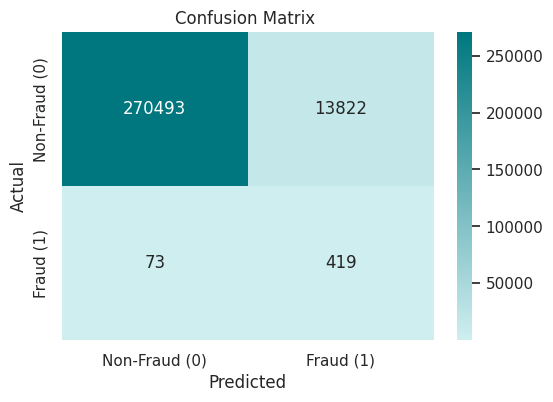

In [ ]:
# Custom color palette
colors = ['#CFEEF0', '#00777F']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Plot the confusion matrix
cm = confusion_matrix(y, iso_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#015156; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 📐 6. One-Class SVM </b></div>

![svm](https://scikit-learn.org/stable/_images/sphx_glr_plot_sgdocsvm_vs_ocsvm_001.png)

Image taken from [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgdocsvm_vs_ocsvm.html#sphx-glr-auto-examples-linear-model-plot-sgdocsvm-vs-ocsvm-py).

<div style="border: 2px solid #00777F; padding: 15px; border-radius: 10px;">
    <p style="font-size: 16px">
        <strong>🌀 One-Class SVM</strong>: This model learns the boundary of normal data points and flags any points outside this boundary as anomalies. It's particularly powerful in high-dimensional spaces where traditional methods may struggle. However, it can be computationally intensive and sensitive to the presence of noise in the data, which can lead to misclassification.
    </p>
</div>

In [ ]:
# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
svm_preds = oc_svm.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
svm_preds = [1 if x == -1 else 0 for x in svm_preds]

# Evaluate the results
print(classification_report(y, svm_preds))
roc_auc = roc_auc_score(y, svm_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.86      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9035432580861518
Confusion Matrix:


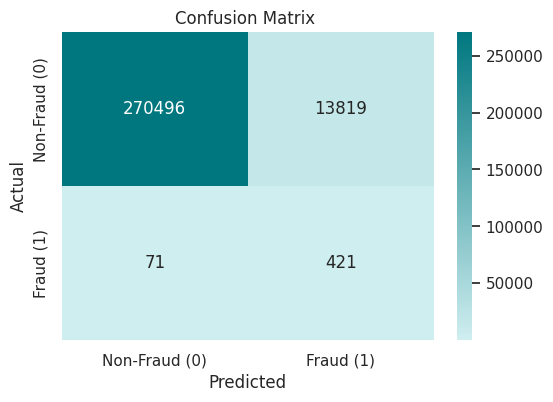

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, svm_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#015156; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 📍 7. Local Outlier Factor (LOF) </b></div>

![lof](https://scikit-learn.org/stable/_images/sphx_glr_plot_lof_outlier_detection_001.png)

Image taken from [here](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html).

<div style="border: 2px solid #00777F; padding: 15px; border-radius: 10px;">
    <p style="font-size: 16px">
        <strong>🔍 Local Outlier Factor (LOF)</strong>: LOF assesses the local density of each data point compared to its neighbors. If a point has a significantly lower density than those around it, it's considered an outlier. This technique is useful for identifying anomalies in varying densities but can be sensitive to the choice of the number of neighbors, which affects its performance.
    </p>
</div>

In [ ]:
# Initialize Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)

# Predict (returns -1 for anomalies and 1 for normal data)
lof_preds = lof.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
lof_preds = [1 if x == -1 else 0 for x in lof_preds]

# Evaluate the results
print(classification_report(y, lof_preds))
roc_auc = roc_auc_score(y, lof_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y, lof_preds))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.00      0.11      0.01       492

    accuracy                           0.95    284807
   macro avg       0.50      0.53      0.49    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.5319646464494823
Confusion Matrix:
[[270130  14185]
 [   436     56]]


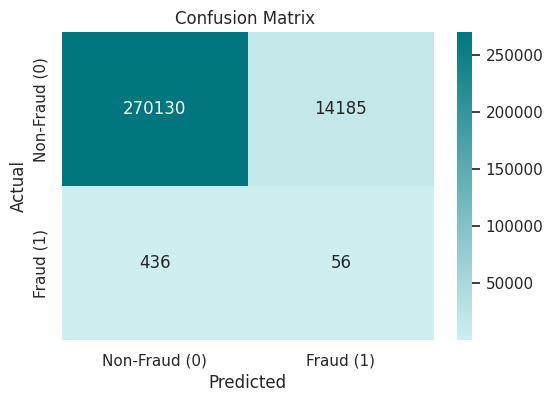

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, lof_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#015156; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 🔗 8. DBSCAN </b></div>

![dbscan](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*znNJOXgNW59YUbE9hsjBjQ.png)

Image taken from [here](https://medium.com/@sachinsoni600517/clustering-like-a-pro-a-beginners-guide-to-dbscan-6c8274c362c4).

<div style="border: 2px solid #00777F; padding: 15px; border-radius: 10px;">
    <p style="font-size: 16px">
        <strong>🔗 DBSCAN (Density-Based Spatial Clustering)</strong>: DBSCAN groups data points based on their density, identifying clusters of similar points and marking isolated points as anomalies. This method is particularly effective at finding irregularly shaped clusters and can handle noise. However, it requires setting parameters like the distance threshold and the minimum number of points for clustering, which can be challenging and affect performance.
    </p>
</div>

In [ ]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit and predict (labels different clusters, outliers labeled as -1)
dbscan_preds = dbscan.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and others to 0 (non-fraud)
dbscan_preds = [1 if x == -1 else 0 for x in dbscan_preds]

# Evaluate the results
print(classification_report(y, dbscan_preds))
roc_auc = roc_auc_score(y, dbscan_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y, dbscan_preds))

              precision    recall  f1-score   support

           0       1.00      0.17      0.28    284315
           1       0.00      0.97      0.00       492

    accuracy                           0.17    284807
   macro avg       0.50      0.57      0.14    284807
weighted avg       1.00      0.17      0.28    284807

ROC AUC Score:  0.568390228746914
Confusion Matrix:
[[ 46979 237336]
 [    14    478]]


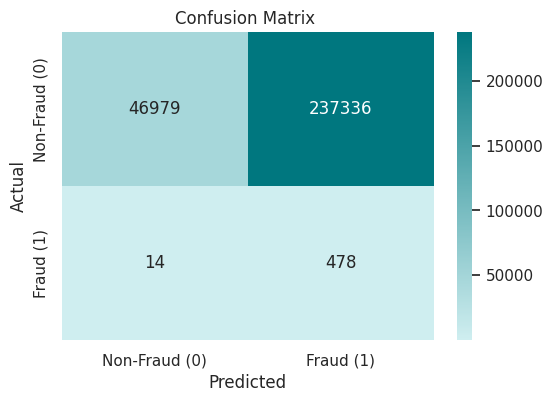

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, dbscan_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#015156; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 🔄 9. Autoencoders </b></div>

![autoencoders](https://www.researchgate.net/publication/353282003/figure/fig3/AS:1046016686039041@1626401220410/A-simple-architecture-for-autoencoders.jpg)

Image taken from [here](https://www.researchgate.net/figure/A-simple-architecture-for-autoencoders_fig3_353282003).

<div style="border: 2px solid #00777F; padding: 15px; border-radius: 10px;">
    <p style="font-size: 16px">
        <strong>🔄 Autoencoders</strong>: These are neural networks designed to compress and reconstruct data. By training on normal transactions, they learn to recreate them effectively. If a transaction cannot be reconstructed well, it's flagged as an anomaly. Autoencoders are great for capturing complex patterns in data, but they require more computational resources and careful tuning of architecture and parameters to perform effectively.
    </p>
</div>

In [ ]:
# Define the autoencoder model
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    encoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(encoded)

    # Latent space
    latent = Dense(4, activation='relu')(encoded)

    # Decoder
    decoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(latent)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    decoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Build and compile the model
autoencoder = build_autoencoder(X_scaled.shape[1])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Train the model on normal transactions (non-fraudulent class, y == 0)
X_train = X_scaled[y == 0]
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

# Calculate reconstruction error for all transactions
reconstructed = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)  # Adjust threshold (90th percentile)
autoen_preds = np.where(mse > threshold, 1, 0)  # 1: anomaly (fraud), 0: normal

# Evaluate the model
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)

Epoch 1/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1.0094 - val_loss: 0.9580
Epoch 2/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.9179 - val_loss: 0.9450
Epoch 3/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.9109 - val_loss: 0.9377
Epoch 4/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.9007 - val_loss: 0.9313
Epoch 5/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.8943 - val_loss: 0.9246
Epoch 6/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.8911 - val_loss: 0.9261
Epoch 7/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.8935 - val_loss: 0.9187
Epoch 8/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.8841 - val_loss: 0.9200
Epoch 9/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.8823 - val_loss: 0.9183
Epoch 10/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.8809 - val_loss: 0.9186
Epoch 11/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.8776 - val_loss: 0.9154
Epoch 12/50
7997/79

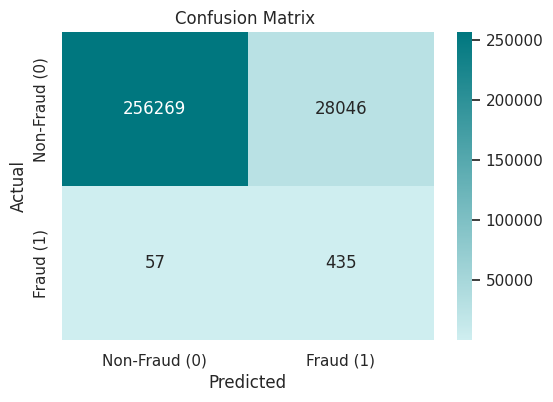

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#015156; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 🛡️ 10. Conclusions </b></div>


Models often prioritize maximizing fraud detection (high recall) but at the cost of low precision, flagging many legitimate transactions as fraudulent.

DBSCAN: Achieved the highest recall (97%), detecting almost all frauds, but its excessive false positives render it impractical due to high costs and customer inconvenience.


One-Class SVM and Isolation Forest: Captured ~85% of frauds, offering a better balance between detecting fraud and reducing false positives, making them more practical for real-world use.